In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats as ss
from autograd.misc import flatten
from autograd.misc.optimizers import adam
from tqdm import trange, tqdm, tqdm_notebook

from autograd import grad
import matplotlib.pyplot as plt

In [2]:
npr.seed(1234)

In this problem setting we are interested in the case given two data sets, a labelled $\mathcal{D}_{Train} = \{(\mathbf{x}_i,y_i)\}_{i=1}^n$ and an unlabelled  $\mathcal{D}_{Target} = \{\mathbf{x}_j\}_{j=n+1}^{n+m}$, with $\mathbf{x} \in \mathbb{R}^d$, a $d$-dimensional feature vector,  and $y \in \mathbb{R}$, a real-valued output, assuming an underlying generative process: 

$$
(X_i,Y_i) \in \mathcal{D}_{Train} \overset{i.i.d.}{\sim} P = P_X \times P_{Y|X}
$$
$$
X_j \in \mathcal{D}_{Target} \overset{i.i.d.}{\sim} Q_X
$$

We first set up our synthetic example data, where both $P_X$ and $Q_X$ will take the form of Normal distributions, and $P_{Y|X} = \mathcal{N}(f(\mathbf{x}),\sigma^2)$, i.e. $Y$ is some deterministic function of $X$ corrupted by some Gaussian noise.

In [3]:
class feature_dist():
    '''
    Just a little class to wrap the behaviour of the distrbutions over
    features. Defines a Gaussian distribution, allows for pdf evaluation 
    and sampling.
    '''
    def __init__(self,mean=0,sd=1):
        self.mean = mean 
        self.sd = sd
    
    def pdf(self,x):
        return(ss.norm.pdf(x,loc=self.mean,scale=self.sd))
    
    def sample(self,num):
        return npr.normal(loc=self.mean,scale=self.sd,size = (num,1))

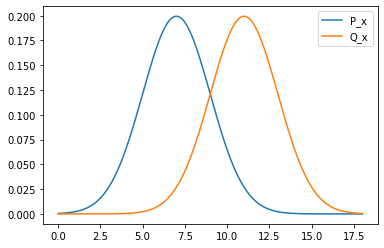

In [4]:
P_x = feature_dist(7,2)
Q_x = feature_dist(11,2)

x = np.linspace(0, 18,1000)

pdf_p = P_x.pdf(x)
pdf_q = Q_x.pdf(x)

plt.plot(x,pdf_p, label = 'P_x')
plt.plot(x,pdf_q, label = 'Q_x')
plt.legend()
plt.show()

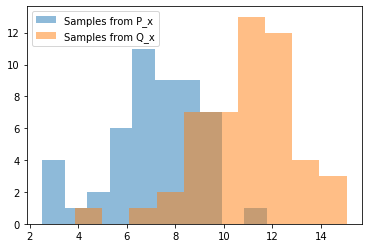

In [5]:
num_samples = 50

samples_p = P_x.sample(num_samples)
samples_q = Q_x.sample(num_samples)

plt.hist(samples_p, alpha = 0.5, label = 'Samples from P_x')
plt.hist(samples_q, alpha = 0.5, label = 'Samples from Q_x')
plt.legend()
plt.show()

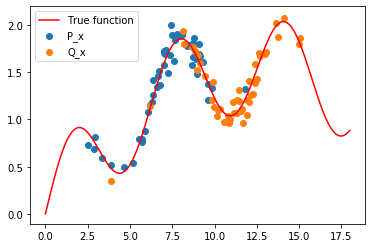

In [6]:
def y_target(x):
    return np.sin(x)/2 + x/4 - x**2/100

def y_noise(n,sd):
    return npr.normal(loc=0,scale=sd,size=(n,1))


y_samples_p = y_target(samples_p) + y_noise(num_samples, 0.1)
y_samples_q = y_target(samples_q) + y_noise(num_samples, 0.1)
true_func = y_target(x)

plt.scatter(samples_p,y_samples_p, label = 'P_x')
plt.scatter(samples_q,y_samples_q, label = 'Q_x')

plt.plot(x, true_func, c = 'r', label = 'True function')

plt.legend()
plt.show()
    

In [7]:
from models import transductive, mc_dropout_concrete
from utils import nice_plot, nice_plot_conc

Optimising parameters: 100%|██████████| 10000/10000 [00:36<00:00, 275.25it/s]


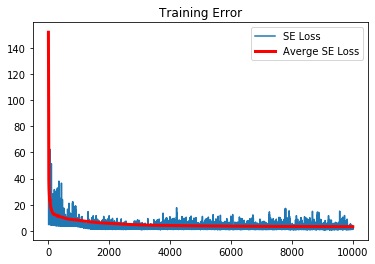

In [8]:
model_concrete = mc_dropout_concrete([1,32,64,1],d_rate = [0.5,0.5,0.5])
model_concrete.train(samples_p, y_samples_p, 10000)

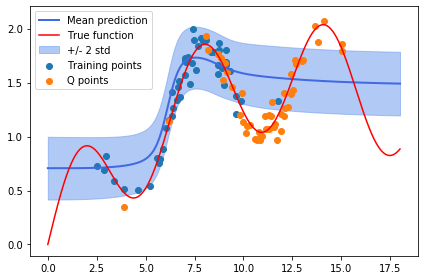

In [9]:
nice_plot_conc(model_concrete,samples_p,y_samples_p,samples_q,y_samples_q,true_func)

Optimising parameters: 100%|██████████| 1000/1000 [1:40:57<00:00,  6.06s/it]


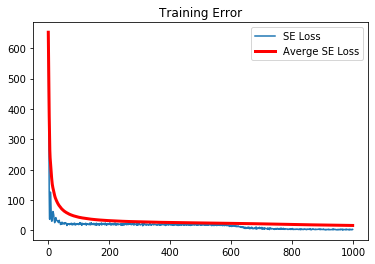

In [10]:
model = transductive([1,32,64,1],d_units = 8)
model.train(samples_p, y_samples_p, samples_q, 1000)

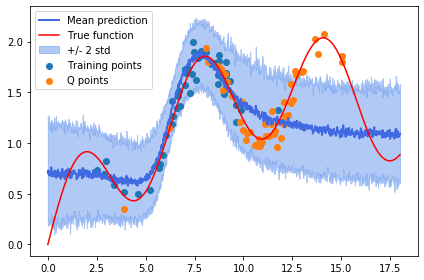

In [11]:
nice_plot(model,samples_p,y_samples_p,samples_q,y_samples_q,true_func)